#### Dataset Description
In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

In [1]:
# For loading packages
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# For calculations
import numpy as np

# For data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Model building, tuning and measuring accuracy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2

# To ignore any warnings
import warnings
warnings.filterwarnings("ignore")

#### Reading The Data

In [2]:
# Reading the train data
train_df = pd.read_csv("train.csv")

# Reading the test data
test_df = pd.read_csv("test.csv")

I'll make a copy of the train and test data incase I need the original datasets.

In [3]:
# Copying the original train and test datasets
train_df_1 = train_df.copy()
test_df_1 = test_df.copy()

Let's review the structure of the dataset - what are the features.

In [4]:
# View columns of the train data
train_df_1.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

There are 13 independent variables and 1 target variable (Transported) in the training dataset. Let's also review the test dataset.

In [5]:
# View columns of the test data
test_df_1.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')

We have the same set of features in the test dataset as we do the training dataset, with the only difference being that the training dataset has the the additional target feature 'Transported'.

Below is a description for each variable.

Data Field Descriptions 
- **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
- **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- **Destination** - The planet the passenger will be debarking to.
- **Age** - The age of the passenger.
- **VIP** - Whether the passenger has paid for special VIP service during the voyage.
- **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- **Name** - The first and last names of the passenger.
- **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

Let's have a look at the data types for each variable of the training dataset.

In [6]:
train_df_1.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

We can see that the features take one of three formats in the training dataset:<br>

- **object** (Categorical variables) - The categorical variables in the training dataset are: PassengerId, HomePlanet, CryoSleep, Cabin, Destination, VIP and Name.<br>
- **float64** (Float variables i.e. Numerical variables which have some decimal values involved) - The Numerical variables in our train dataset are: Age, RoomService, FoodCourt, ShoppingMall, Spa and VRDeck.<br>
- **bool** (Boolean variables i.e. a variable that has one of the two possible values e.g. True or False) - The Boolean Variables in our dataset is Transported.<br>

Le's look at the shape of our train and test dataset.

In [7]:
# Print the shape of the training dataset
print("The shape of the training dataset is: ", train_df_1.shape)

# Print the shape of the test dataset
print("The shape of the test dataset is: ", test_df_1.shape)

The shape of the training dataset is:  (8693, 14)
The shape of the test dataset is:  (4277, 13)


We have 8693 rows and 14 columns in the training dataset and 4277 rows and 13 columns in the test dataset. <br>

***Univeraiate Analysis***

Here, we're going to analyse each feature individually, to better understand the distribution of its values.

***Target Variable***

We will first look at the target variable i.e. Transported. Since it is a categorical variable, we'll look at it's percentage distrubition and bar plot.

In [8]:
# Calculating the normalised proportions
train_df_1['Transported'].value_counts(normalize=True)

True     0.503624
False    0.496376
Name: Transported, dtype: float64

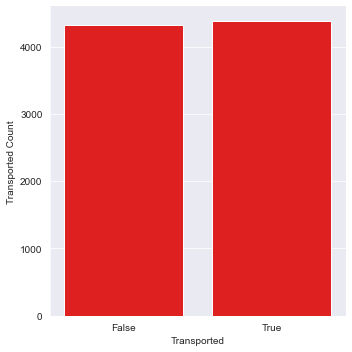

In [9]:
# Visualising the above
ax = sns.catplot(x = "Transported", data = train_df_1, kind = "count", color = "r")
ax.set_axis_labels("Transported", "Transported Count")

Approximately half of all passengers were Transported to another dimension.<br>

Now let's visualise the independent categorical features next.

***Independent Variable (Categorical)***

<AxesSubplot:title={'center':'VIP'}>

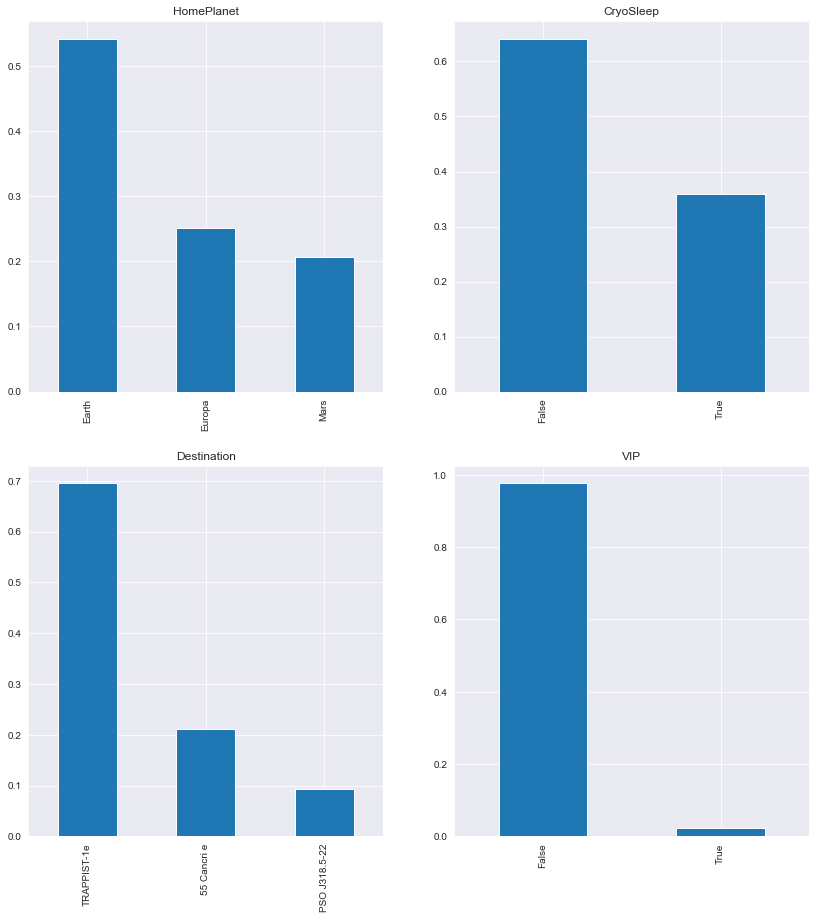

In [10]:
# Visualising independent categorical features
plt.figure(figsize = (14, 15))

plt.subplot(221)
train_df_1['HomePlanet'].value_counts(normalize = True).plot.bar(title = 'HomePlanet')

plt.subplot(222)
train_df_1['CryoSleep'].value_counts(normalize = True).plot.bar(title = 'CryoSleep')

plt.subplot(223)
train_df_1['Destination'].value_counts(normalize = True).plot.bar(title = 'Destination')

plt.subplot(224)
train_df_1['VIP'].value_counts(normalize = True).plot.bar(title = 'VIP')


From the bar plots, we can see the following:
- About 50% of passengers are from Earth
- Approximately 30% of passengers were in CryoSleep
- Almost 70% of passengers were traveling to TRAPPIST-1e
- Less than 1% of passengers paid for the VIP service

Now let's look at the cabin column, which takes the form of deck/num/side. 

<AxesSubplot:title={'center':'CabinSide'}>

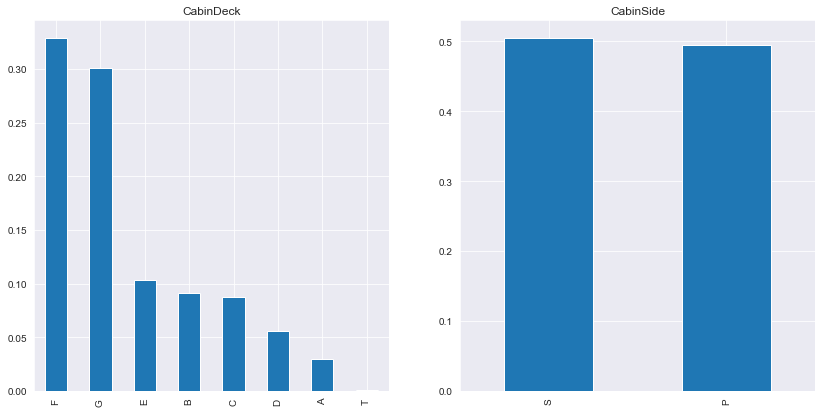

In [11]:
# Extracting the CabinDeck, CabinNo. and CabinSide features from Cabin
train_df_1[["CabinDeck", "CabinNo.", "CabinSide"]] = train_df_1["Cabin"].str.split('/', expand = True)

#Visualize cabin feature
plt.figure(figsize = (14, 15))
plt.subplot(221)
train_df_1['CabinDeck'].value_counts(normalize= True).plot.bar(title = 'CabinDeck')
plt.subplot(222)
train_df_1['CabinSide'].value_counts(normalize= True).plot.bar(title = 'CabinSide')

From the above bar charts, we can see that:
- About 60% of all passengers (in the train set) were on deck F and G
- The passengers in the train set seemed to be almost equally distrubuted amongst the Cabin sides, S and P

That concludes our univariate analysis of the categorical variables. Now let's visualise the numerical variables.



#### Age

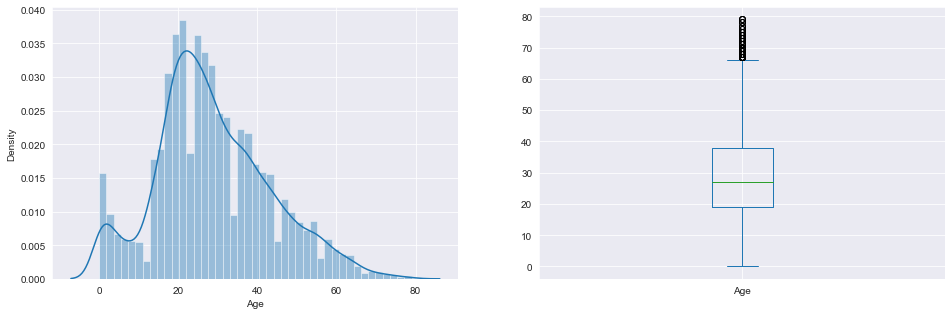

In [12]:
# Visualising the Age variable
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['Age']);
plt.subplot(122)
train_df_1['Age'].plot.box(figsize = (16,5))
plt.show()

The distrubution is that of a gamma distrubution (given the non-negative nature of Age) but it loosely follows a normal distribution (***Need to query this***). It's also worth pointing out there are some outliers, shown by the boxplot.

#### Room Service

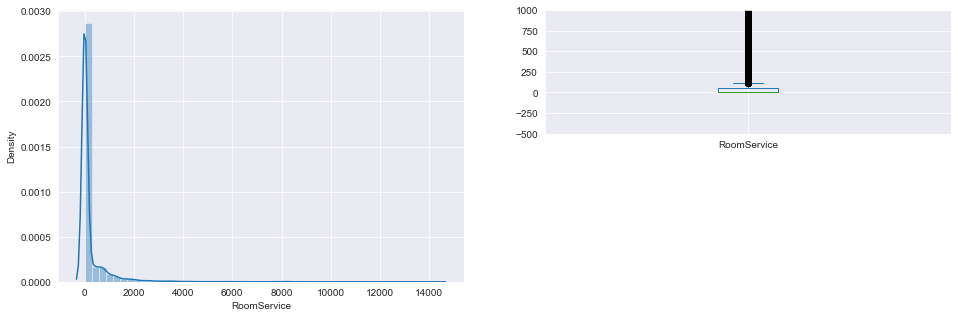

In [13]:
# Visualising the Room Service variable

plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['RoomService'])
plt.subplot(222)
train_df_1['RoomService'].plot.box(figsize = (16,5))
plt.ylim([-500,1000])
plt.show()

As we can see in the distribution, most of the data is towards the left, which means we can't assume it's normally distributed and there are a lot of outliers. We must normalise this data later!

#### Spa

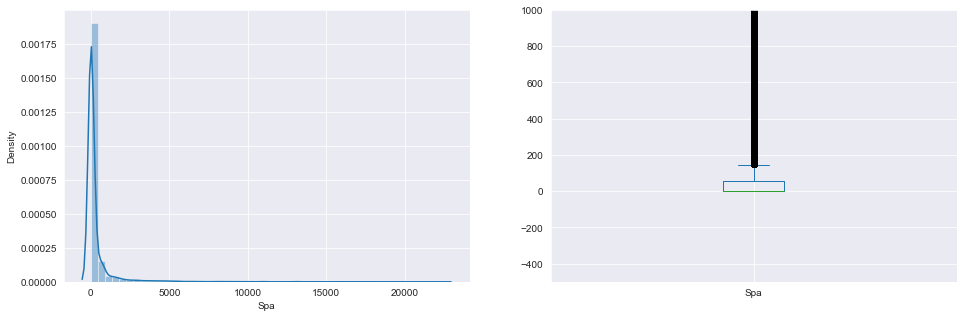

In [14]:
# Visualising the Spa variable
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['Spa'])
plt.subplot(122)
train_df_1['Spa'].plot.box(figsize = (16,5))
plt.ylim([-500, 1000])
plt.show()

The Spa variable has a very similar distribution as that of RoomService. It contains a lot of outliers and is clearly not normally distributed.

Now, RoomService, FoodCourt, ShoppingMall, Spa and VRDeck are the amount the passenger spent on those amenities. It will be interesting to see if FoodCourt, ShoppingMall and VRDeck follow a similar distribution as RoomService and Spa.

#### FoodCourt

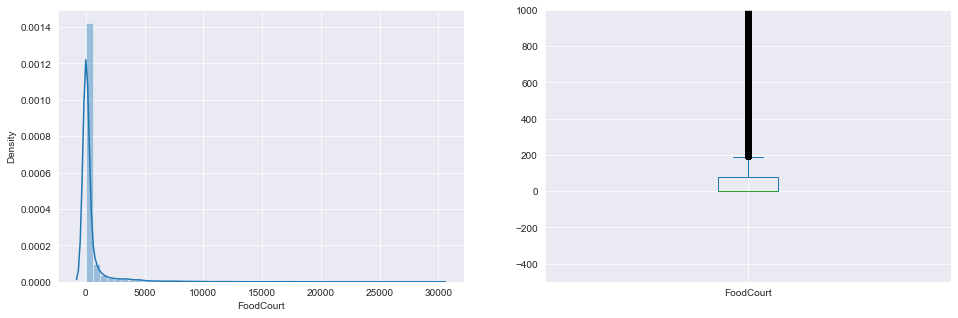

In [15]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['FoodCourt'])
plt.subplot(122)
train_df_1['FoodCourt'].plot.box(figsize = (16, 5))
plt.ylim([-500,1000])
plt.show()

#### ShoppingMall

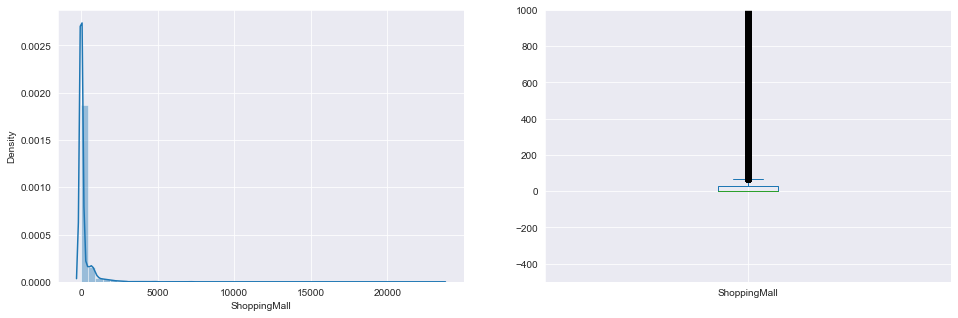

In [16]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['ShoppingMall'])
plt.subplot(122)
train_df_1['ShoppingMall'].plot.box(figsize = (16, 5))
plt.ylim([-500,1000])
plt.show()

#### VRDeck

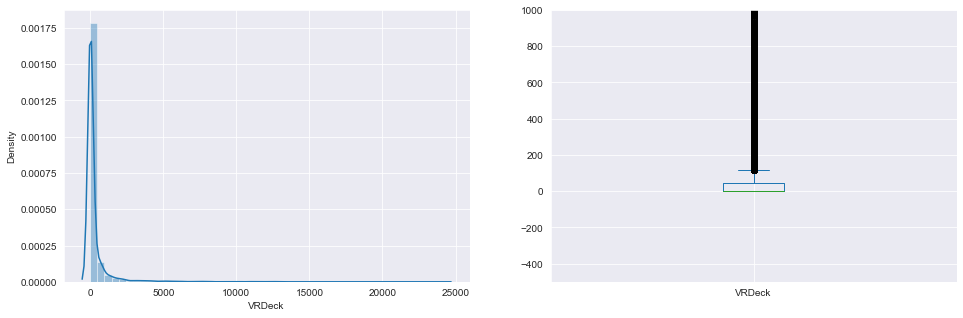

In [17]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df_1['VRDeck'])
plt.subplot(122)
train_df_1['VRDeck'].plot.box(figsize = (16, 5))
plt.ylim([-500,1000])
plt.show()

As we can see from the last few plots, FoodCourt, ShoppingMall and VRDeck have very similar distrubutions to RoomService and Space; skewed towards the left and not normal. They all also have a lot of outliers.

#### Bivariate Analysis

Now that we've completed a univariate analysis of the variables, we will now perform a bivariate analyis, that is to say, the relationship with each of the features with one another, but most importantly, how each of the features relate to the target variable - Transported.

In [18]:
HomePlanet_Transported = train_df_1.groupby('HomePlanet').aggregate({'Transported' : 'sum', 'PassengerId' : 'size'}).reset_index()
HomePlanet_Transported['TransportedPercentage'] = HomePlanet_Transported['Transported'] / HomePlanet_Transported['PassengerId']


CryoSleep_Transported = train_df_1.groupby('CryoSleep').aggregate({'Transported' : 'sum', 'PassengerId' : 'size'}).reset_index()
CryoSleep_Transported['TransportedPercentage'] = CryoSleep_Transported['Transported'] / CryoSleep_Transported['PassengerId']

Destination_Transported = train_df_1.groupby('Destination').aggregate({'Transported' : 'sum', 'PassengerId' : 'size'}).reset_index()
Destination_Transported['TransportedPercentage'] = Destination_Transported['Transported'] / Destination_Transported['PassengerId']

Destination_Transported = train_df_1.groupby('Destination').aggregate({'Transported' : 'sum', 'PassengerId' : 'size'}).reset_index()
Destination_Transported['TransportedPercentage'] = Destination_Transported['Transported'] / Destination_Transported['PassengerId']

VIP_Transported = train_df_1.groupby('VIP').aggregate({'Transported' : 'sum', 'PassengerId' : 'size'}).reset_index()
VIP_Transported['TransportedPercentage'] = VIP_Transported['Transported'] / VIP_Transported['PassengerId']

Now let's plot these relations of the categorical variables and the Transported target variable.

<AxesSubplot:xlabel='VIP', ylabel='TransportedPercentage'>

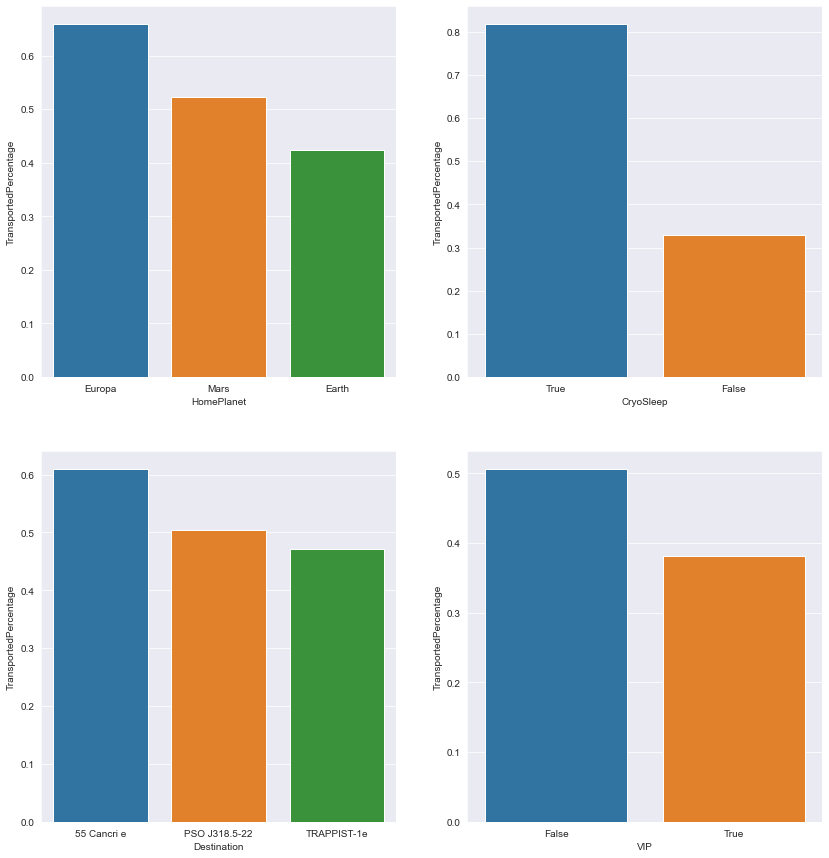

In [19]:

# Visualize categorical features vs target variable
plt.figure(figsize = (14, 15)) 
plt.subplot(221)
sns.barplot(x = "HomePlanet", y = "TransportedPercentage", data = HomePlanet_Transported, order = HomePlanet_Transported.sort_values('TransportedPercentage', ascending = False).HomePlanet)
plt.subplot(222)
sns.barplot(x = "CryoSleep", y = "TransportedPercentage", data = CryoSleep_Transported, order = CryoSleep_Transported.sort_values('TransportedPercentage', ascending = False).CryoSleep)
plt.subplot(223)
sns.barplot(x = "Destination", y = "TransportedPercentage", data = Destination_Transported, order = Destination_Transported.sort_values('TransportedPercentage', ascending = False).Destination)
plt.subplot(224)
sns.barplot(x = "VIP", y = "TransportedPercentage", data = VIP_Transported, order = VIP_Transported.sort_values('TransportedPercentage', ascending = False).VIP)

From the plots we can make the following inferences:
- Approximately 65% of Passengers from Europa were Transported
- About 82% of Passengers in CryoSleep were Transported
- The ratio of Passengers Transported from the Destinations '55 Cancri e', 'PSO J318.5-22' and 'TRAPPIST-1e' is about 12:10:9
- About 38% of Passengers that paid for VIP services were transported

Next we'll perform the same bivariate analysis for CabinDeck and CabinSide columns and how they relate to the target variable, Transported.

<AxesSubplot:xlabel='CabinSide', ylabel='TransportedPercentage'>

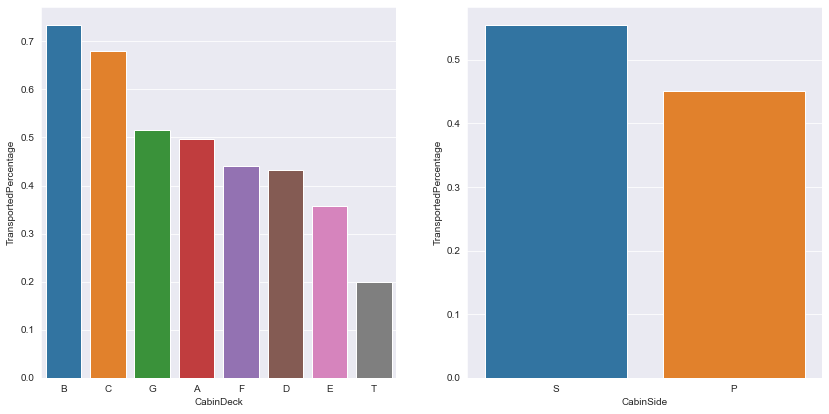

In [20]:
CabinDeck_Transported = train_df_1.groupby('CabinDeck').aggregate({'Transported' : 'sum', 'PassengerId' : 'size'}).reset_index()

CabinDeck_Transported['TransportedPercentage'] = CabinDeck_Transported['Transported'] / CabinDeck_Transported['PassengerId']

CabinSide_Transported = train_df_1.groupby('CabinSide').aggregate({'Transported' : 'sum', 'PassengerId' : 'size'}).reset_index()

CabinSide_Transported['TransportedPercentage'] = CabinSide_Transported['Transported'] / CabinSide_Transported['PassengerId']

# Visualising the Cabin features against the target feature
plt.figure(figsize = (14,15))
plt.subplot(221)
sns.barplot(x = "CabinDeck", y = "TransportedPercentage", data = CabinDeck_Transported, order = CabinDeck_Transported.sort_values('TransportedPercentage', ascending = False).CabinDeck)
plt.subplot(222)
sns.barplot(x = "CabinSide", y = "TransportedPercentage", data = CabinSide_Transported, order = CabinSide_Transported.sort_values('TransportedPercentage', ascending = False).CabinSide)

- Cabin Deck B and C have the highest percentage of Passengers being Transported
- The proportion of Passengers in the Cabin Side S Transported is greater than those in Cabin Side P

The PassengerId column has instances in the form 'gggg_pp' where gggg represents the group they were travelling with, i.e. family or friends etc. pp represents the number within the group. We want to see if there's any relation between PassengerId and being Transported. In other words, were specific groups or individuals Transported based on who they travelled with?


In [21]:
# Extract PassengerGroup column from PassengerId column
train_df_1["PassengerGroup"] = train_df_1["PassengerId"].str.split('_', expand = True)[0]

#Create dataframe -No_People_In_PassengerGroup that contains the PassengerGroup and the no passengers in the group
No_People_In_PassengerGroup = train_df_1.groupby('PassengerGroup') 

In [4]:
print('test')
###dfdfdfddf


test


xcv bcxvxvxdvvxvfvf
